In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import random

import scipy.stats as sp
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',25)
pd.set_option('display.max_rows',25)

import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()

df = pd.read_csv('../data/vehicles.csv', low_memory=False)

df_copy = df.copy()

In [2]:
###################################################################################################

In [3]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [4]:
###################################################################################################

In [5]:
def remove_null_tupiles(df,feature):
    df.dropna(subset=[feature], inplace = True)
    
def remove_outliers(df,feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    
    filt = ( ((df[feature]) < (q1-(1.5*iqr))) | ( df[feature] > (q3 + (1.5 * iqr)) ) )

    df.drop(index=df[filt].index, inplace = True)
    
def min_max_norm(v_min, v_max, v):
    num = v - v_min
    den = v_max - v_min
    
    new_min = 0.0
    new_max = 1.0
    mult = (new_max - new_min) + new_min
    
    new_v = ( num / den ) * mult
    
    return new_v

In [6]:
###################################################################################################

In [7]:
# Remove Unused Features
features_to_drop = ['id','url','condition','cylinders','VIN','drive','size','type','paint_color','image_url','description','county']
df_copy = df_copy.drop(features_to_drop,axis=1)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   region_url    426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  state         426880 non-null  object 
 11  lat           420331 non-null  float64
 12  long          420331 non-null  float64
 13  posting_date  426812 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 45.6+ MB


In [8]:
###################################################################################################

In [9]:
# Null Info
feature = 'price'
df_copy[feature].info()
df_copy[feature].isna().sum() # Number of null tuples
(df_copy[feature].isna().sum()/len(df_copy.index)) * 100 # % of data that is null
df_copy[feature].value_counts()
df_copy[feature].unique()

# temp_filt = (df_copy[feature].value_counts() == 0)
# temp_filt.value_counts()

<class 'pandas.core.series.Series'>
RangeIndex: 426880 entries, 0 to 426879
Series name: price
Non-Null Count   Dtype
--------------   -----
426880 non-null  int64
dtypes: int64(1)
memory usage: 3.3 MB


0

0.0

0        32895
6995      3169
7995      3129
9995      2867
8995      2837
         ...  
21298        1
49217        1
63195        1
19709        1
17873        1
Name: price, Length: 15655, dtype: int64

array([ 6000, 11900, 21000, ...,  6328, 19853, 17873], dtype=int64)

In [10]:
###################################################################################################

In [11]:
# Oultier Info for Categorical
df_copy_q1 = df_copy[feature].value_counts().quantile(0.25)
df_copy_q1

df_copy_q3 = df_copy[feature].value_counts().quantile(0.75)
df_copy_q3

df_copy_iqr = df_copy_q3 - df_copy_q1
df_copy_iqr

df_copy_filt = ( ((df_copy[feature].value_counts()) < (df_copy_q1-(1.5*df_copy_iqr))) | ( (df_copy[feature].value_counts()) > (df_copy_q3 + (1.5 * df_copy_iqr)) ) )

(df_copy_q1-(1.5*df_copy_iqr))

(df_copy_q3 + (1.5 * df_copy_iqr))

df_copy_filt

1.0

6.0

5.0

-6.5

13.5

0         True
6995      True
7995      True
9995      True
8995      True
         ...  
21298    False
49217    False
63195    False
19709    False
17873    False
Name: price, Length: 15655, dtype: bool

In [12]:
###################################################################################################

In [13]:
# Oultier Info for Numerical
df_copy_q1 = df_copy[feature].quantile(0.25)
df_copy_q1

df_copy_q3 = df_copy[feature].quantile(0.75)
df_copy_q3

df_copy_iqr = df_copy_q3 - df_copy_q1
df_copy_iqr

df_copy_filt = ( ((df_copy[feature]) < (df_copy_q1-(1.5*df_copy_iqr))) | ( df_copy[feature] > (df_copy_q3 + (1.5 * df_copy_iqr)) ) )
(df_copy_q1-(1.5*df_copy_iqr))
(1.5 * df_copy_iqr)

df_copy_filt

df_copy_filt.value_counts()

5900.0

26485.75

20585.75

-24978.625

30878.625

0         False
1         False
2         False
3         False
4         False
          ...  
426875    False
426876    False
426877    False
426878    False
426879    False
Name: price, Length: 426880, dtype: bool

False    418703
True       8177
Name: price, dtype: int64

In [14]:
###################################################################################################

In [15]:
# Change region column datatype to category
df_copy.region = df_copy.region.astype('category')

# Label encode region column
df_copy['region_labelEncoded'] = le.fit_transform(df_copy['region'])

df_copy['region'].value_counts()
df_copy['region_labelEncoded'].value_counts()

columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: region, Length: 404, dtype: int64

67     3608
158    3562
340    2988
100    2985
119    2983
       ... 
215      28
335      14
165      11
115       9
384       8
Name: region_labelEncoded, Length: 404, dtype: int64

In [16]:
###################################################################################################

In [17]:
# Change region_url column datatype to category
df_copy.region_url = df_copy.region_url.astype('category')

# Label encode region_url column
df_copy['region_url_labelEncoded'] = le.fit_transform(df_copy['region_url'])

In [18]:
###################################################################################################

In [19]:
# Change year column datatype to category
# Attempted but couldn't
# df_copy['year'] = df_copy['year'].round(0)
# df_copy['year'] = df_copy['year'].apply(np.int64)

# Drop null entries for year
empty_df_year_index = df_copy[df_copy['year'].isnull()].index
df_copy.drop(index=empty_df_year_index, inplace = True)

# Remove outliers for year
remove_outliers(df_copy,'year')

# Bin year
df_copy['year_qcut'] = pd.qcut(df_copy['year'], q=10, duplicates='drop')

In [20]:
###################################################################################################

In [21]:
# Change manufacturer column datatype to category
df_copy.manufacturer = df_copy.manufacturer.astype('category')

# Drop null entries for manufacturer
empty_df_manufacturer_index = df_copy[df_copy['manufacturer'].isnull()].index
df_copy.drop(index=empty_df_manufacturer_index, inplace = True)

# Label encode manufacturer column
df_copy['manufacturer_labelEncoded'] = le.fit_transform(df_copy['manufacturer'])

In [22]:
###################################################################################################

In [23]:
# Change model column datatype to category
df_copy.model = df_copy.model.astype('category')

# Drop null entries for model
empty_df_model_index = df_copy[df_copy['model'].isnull()].index
df_copy.drop(index=empty_df_model_index, inplace = True)

# Label encode model column
df_copy['model_labelEncoded'] = le.fit_transform(df_copy['model'])

In [24]:
###################################################################################################

In [25]:
# Change fuel column datatype to category
df_copy.fuel = df_copy.fuel.astype('category')

# Drop null entries for fuel
empty_df_fuel_index = df_copy[df_copy['fuel'].isnull()].index
df_copy.drop(index=empty_df_fuel_index, inplace = True)

# Create Copy of Fuel
df_copy['fuel_copy'] = df_copy['fuel']

# One Hot Encoding of fuel
df_copy = pd.get_dummies(df_copy, columns=['fuel_copy'], prefix='oneHot_fuel')

In [26]:
###################################################################################################

In [27]:
# Drop null entries for odometer
empty_df_odometer_index = df_copy[df_copy['odometer'].isnull()].index
df_copy.drop(index=empty_df_odometer_index, inplace = True)

# Remove outliers for odometer
remove_outliers(df_copy,'odometer')

# Bin odometer
df_copy['odometer_qcut'] = pd.qcut(df_copy['odometer'], q=10, duplicates='drop')

In [28]:
###################################################################################################

In [29]:
# Drop null entries for title_status
empty_df_title_status_index = df_copy[df_copy['title_status'].isnull()].index
df_copy.drop(index=empty_df_title_status_index, inplace = True)

# Create Copy of title_status
df_copy['title_status_copy'] = df_copy['title_status']

# One Hot Encoding of fuel
df_copy = pd.get_dummies(df_copy, columns=['title_status_copy'], prefix='oneHot_title_status')

In [30]:
###################################################################################################

In [31]:
# Drop null entries for transmission
empty_df_transmission_index = df_copy[df_copy['transmission'].isnull()].index
df_copy.drop(index=empty_df_transmission_index, inplace = True)

# Create Copy of title_status
df_copy['transmission_copy'] = df_copy['transmission']

# One Hot Encoding of fuel
df_copy = pd.get_dummies(df_copy, columns=['transmission_copy'], prefix='oneHot_transmission')

In [32]:
###################################################################################################

In [33]:
# Change title_status column datatype to category
df_copy.title_status = df_copy.title_status.astype('category')

In [34]:
###################################################################################################

In [35]:
# Change transmission column datatype to category
df_copy.transmission = df_copy.transmission.astype('category')

In [36]:
###################################################################################################

In [37]:
# Change state column datatype to category
df_copy.state = df_copy.state.astype('category')

# Label encode state column
df_copy['state_labelEncoded'] = le.fit_transform(df_copy['state'])

In [38]:
###################################################################################################

In [39]:
# Drop null entries for lat
empty_df_lat_index = df_copy[df_copy['lat'].isnull()].index
df_copy.drop(index=empty_df_lat_index, inplace = True)

# Bin lat
df_copy['lat_qcut'] = pd.qcut(df_copy['lat'], q=10, duplicates='drop')

In [40]:
###################################################################################################

In [41]:
# Bin long
df_copy['long_qcut'] = pd.qcut(df_copy['long'], q=10, duplicates='drop')

In [42]:
###################################################################################################

In [43]:
# Take only the dates
df_copy['posting_date'] = df_copy['posting_date'].str[0:10]

# Split dates by year month day
df_copy['posting_date_split'] = df_copy['posting_date'].str.split('-')

# Create new Columns to change datatypes
# 0 is year * 365 days
# 1 is month * 30.5 days
# 2 is day 
df_copy['posting_date_year'] = df_copy['posting_date_split'].str[0]
df_copy['posting_date_month'] = df_copy['posting_date_split'].str[1]
df_copy['posting_date_day'] = df_copy['posting_date_split'].str[2]

# Change Datatype of Columns
df_copy.posting_date_year = df_copy.posting_date_year.astype('int64')
df_copy.posting_date_month = df_copy.posting_date_month.astype('int64')
df_copy.posting_date_day = df_copy.posting_date_day.astype('int64')

# Create a new column to have posting_date as number of days from year 0000 month 00  day 00 
df_copy['posting_date_num'] = ( (df_copy['posting_date_year'])*365 ) + ( (df_copy['posting_date_month'])*30.5 ) + (df_copy['posting_date_day'])

# Remove original posting_date column and newly created columns
features_to_drop = ['posting_date','posting_date_split','posting_date_year','posting_date_month','posting_date_day']
df_copy = df_copy.drop(features_to_drop,axis=1)

# Bin posting_date_num
df_copy['posting_date_num_qcut'] = pd.qcut(df_copy['posting_date_num'], q=10, duplicates='drop')

In [44]:
###################################################################################################

In [45]:
# Remove outliers for price
remove_outliers(df_copy,'price')

# Bin price
df_copy['price_qcut'] = pd.qcut(df_copy['price'], q=10, duplicates='drop')

# Remove prices that were 0
df_copy_price_is0_filt = df_copy['price'] == 0
df_copy.drop(index=df_copy[df_copy_price_is0_filt].index,inplace = True)

# Remove prices that are less than 0
df_copy_price_is_less0_filt = df_copy['price'] < 0
df_copy.drop(index=df_copy[df_copy_price_is_less0_filt].index,inplace = True)

df_copy['price'].value_counts()

6995     2936
7995     2869
8995     2608
9995     2572
29990    2557
         ... 
24246       1
20446       1
11097       1
9272        1
19853       1
Name: price, Length: 13589, dtype: int64

6995     2936
7995     2869
8995     2608
9995     2572
29990    2557
         ... 
24246       1
20446       1
11097       1
9272        1
19853       1
Name: price, Length: 13589, dtype: int64

In [46]:
###################################################################################################

In [47]:
# Final Feature Set
df_copy.info()

# Dataset Sample
df_copy.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337250 entries, 27 to 426879
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   region                          337250 non-null  category
 1   region_url                      337250 non-null  category
 2   price                           337250 non-null  int64   
 3   year                            337250 non-null  float64 
 4   manufacturer                    337250 non-null  category
 5   model                           337250 non-null  category
 6   fuel                            337250 non-null  category
 7   odometer                        337250 non-null  float64 
 8   title_status                    337250 non-null  category
 9   transmission                    337250 non-null  category
 10  state                           337250 non-null  category
 11  lat                             337250 non-null  float64 
 12  l

,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state,lat,...,oneHot_title_status_parts only,oneHot_title_status_rebuilt,oneHot_title_status_salvage,oneHot_transmission_automatic,oneHot_transmission_manual,oneHot_transmission_other,state_labelEncoded,lat_qcut,long_qcut,posting_date_num,posting_date_num_qcut,price_qcut
420394,madison,https://madison.craigslist.org,2800,1998.0,chevrolet,malibu,gas,79000.0,clean,automatic,wi,43.1393,...,0,0,0,1,0,0,48,"(42.99, 45.082]","(-94.635, -88.167]",737814.0,"(737812.0, 737815.0]","(1000.0, 4950.0]"
77971,denver,https://denver.craigslist.org,3950,2008.0,mercury,milan premier,gas,163000.0,clean,automatic,co,39.6710,...,0,0,0,1,0,0,5,"(39.185, 40.5]","(-117.048, -104.736]",737818.5,"(737817.0, 737818.5]","(1000.0, 4950.0]"
426263,wausau,https://wausau.craigslist.org,37590,2019.0,acura,mdx advance pkg sport,other,30356.0,clean,other,wi,44.9600,...,0,0,0,0,0,1,48,"(42.99, 45.082]","(-94.635, -88.167]",737791.0,"(737790.999, 737796.0]","(35999.0, 58448.0]"


In [48]:
# Make a Dataset with only Numerical Features
df_num_only_copy = df_copy.copy()
features_to_drop = ['region','region_url','manufacturer','model','fuel','title_status','transmission','state','price_qcut','year_qcut','odometer_qcut','lat_qcut','long_qcut','posting_date_num_qcut']
df_num_only_copy = df_num_only_copy.drop(features_to_drop,axis=1)

os.makedirs('../proj6', exist_ok = True)
df_num_only_copy.to_csv('../proj6/vehicles_num_no_norm.csv', index=False)

# Normalize Dataset with only Numerical Features
df_num_only_copy_norm = pd.DataFrame(min_max.fit_transform(df_num_only_copy), columns = df_num_only_copy.columns)

df_num_only_copy_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337250 entries, 0 to 337249
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   price                           337250 non-null  float64
 1   year                            337250 non-null  float64
 2   odometer                        337250 non-null  float64
 3   lat                             337250 non-null  float64
 4   long                            337250 non-null  float64
 5   region_labelEncoded             337250 non-null  float64
 6   region_url_labelEncoded         337250 non-null  float64
 7   manufacturer_labelEncoded       337250 non-null  float64
 8   model_labelEncoded              337250 non-null  float64
 9   oneHot_fuel_diesel              337250 non-null  float64
 10  oneHot_fuel_electric            337250 non-null  float64
 11  oneHot_fuel_gas                 337250 non-null  float64
 12  oneHot_fuel_hybr

In [49]:
df_num_only_copy_norm.describe()
df_num_only_copy_norm.describe().to_csv('vehicles_cleaned_describe.csv')

,price,year,odometer,lat,long,region_labelEncoded,region_url_labelEncoded,manufacturer_labelEncoded,model_labelEncoded,oneHot_fuel_diesel,oneHot_fuel_electric,oneHot_fuel_gas,oneHot_fuel_hybrid,oneHot_fuel_other,oneHot_title_status_clean,oneHot_title_status_lien,oneHot_title_status_missing,oneHot_title_status_parts only,oneHot_title_status_rebuilt,oneHot_title_status_salvage,oneHot_transmission_automatic,oneHot_transmission_manual,oneHot_transmission_other,state_labelEncoded,posting_date_num
count,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000,337250.000000
mean,0.310840,0.649102,0.334385,0.733504,0.201069,0.479973,0.489336,0.454313,0.507738,0.051259,0.004157,0.855644,0.013257,0.075683,0.965767,0.003647,0.000611,0.000252,0.019606,0.010117,0.782941,0.044993,0.172065,0.471332,0.635603
std,0.219013,0.201539,0.219471,0.035628,0.055076,0.292827,0.290529,0.287076,0.284605,0.220525,0.064342,0.351451,0.114374,0.264490,0.181827,0.060281,0.024707,0.015874,0.138641,0.100074,0.412243,0.207290,0.377438,0.301690,0.288438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.128219,0.518519,0.141887,0.710478,0.156663,0.203474,0.218447,0.225000,0.263653,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.180000,0.393443
50%,0.266036,0.703704,0.320213,0.737994,0.219904,0.488834,0.497573,0.375000,0.506375,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.460000,0.721311
75%,0.461923,0.814815,0.490591,0.757210,0.241673,0.719603,0.735437,0.750000,0.768246,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.740000,0.901639
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
df_num_only_copy_norm.corr()['price']

price                             1.000000
year                              0.604574
odometer                         -0.552524
lat                              -0.010337
long                             -0.054035
region_labelEncoded              -0.022539
region_url_labelEncoded          -0.024843
manufacturer_labelEncoded        -0.050775
model_labelEncoded                0.048560
oneHot_fuel_diesel                0.223960
oneHot_fuel_electric              0.034592
oneHot_fuel_gas                  -0.278525
oneHot_fuel_hybrid               -0.025310
oneHot_fuel_other                 0.185897
oneHot_title_status_clean         0.085960
oneHot_title_status_lien          0.009547
oneHot_title_status_missing      -0.028487
oneHot_title_status_parts only   -0.018515
oneHot_title_status_rebuilt      -0.061469
oneHot_title_status_salvage      -0.066805
oneHot_transmission_automatic    -0.295306
oneHot_transmission_manual       -0.078981
oneHot_transmission_other         0.365915
state_label

<AxesSubplot: >

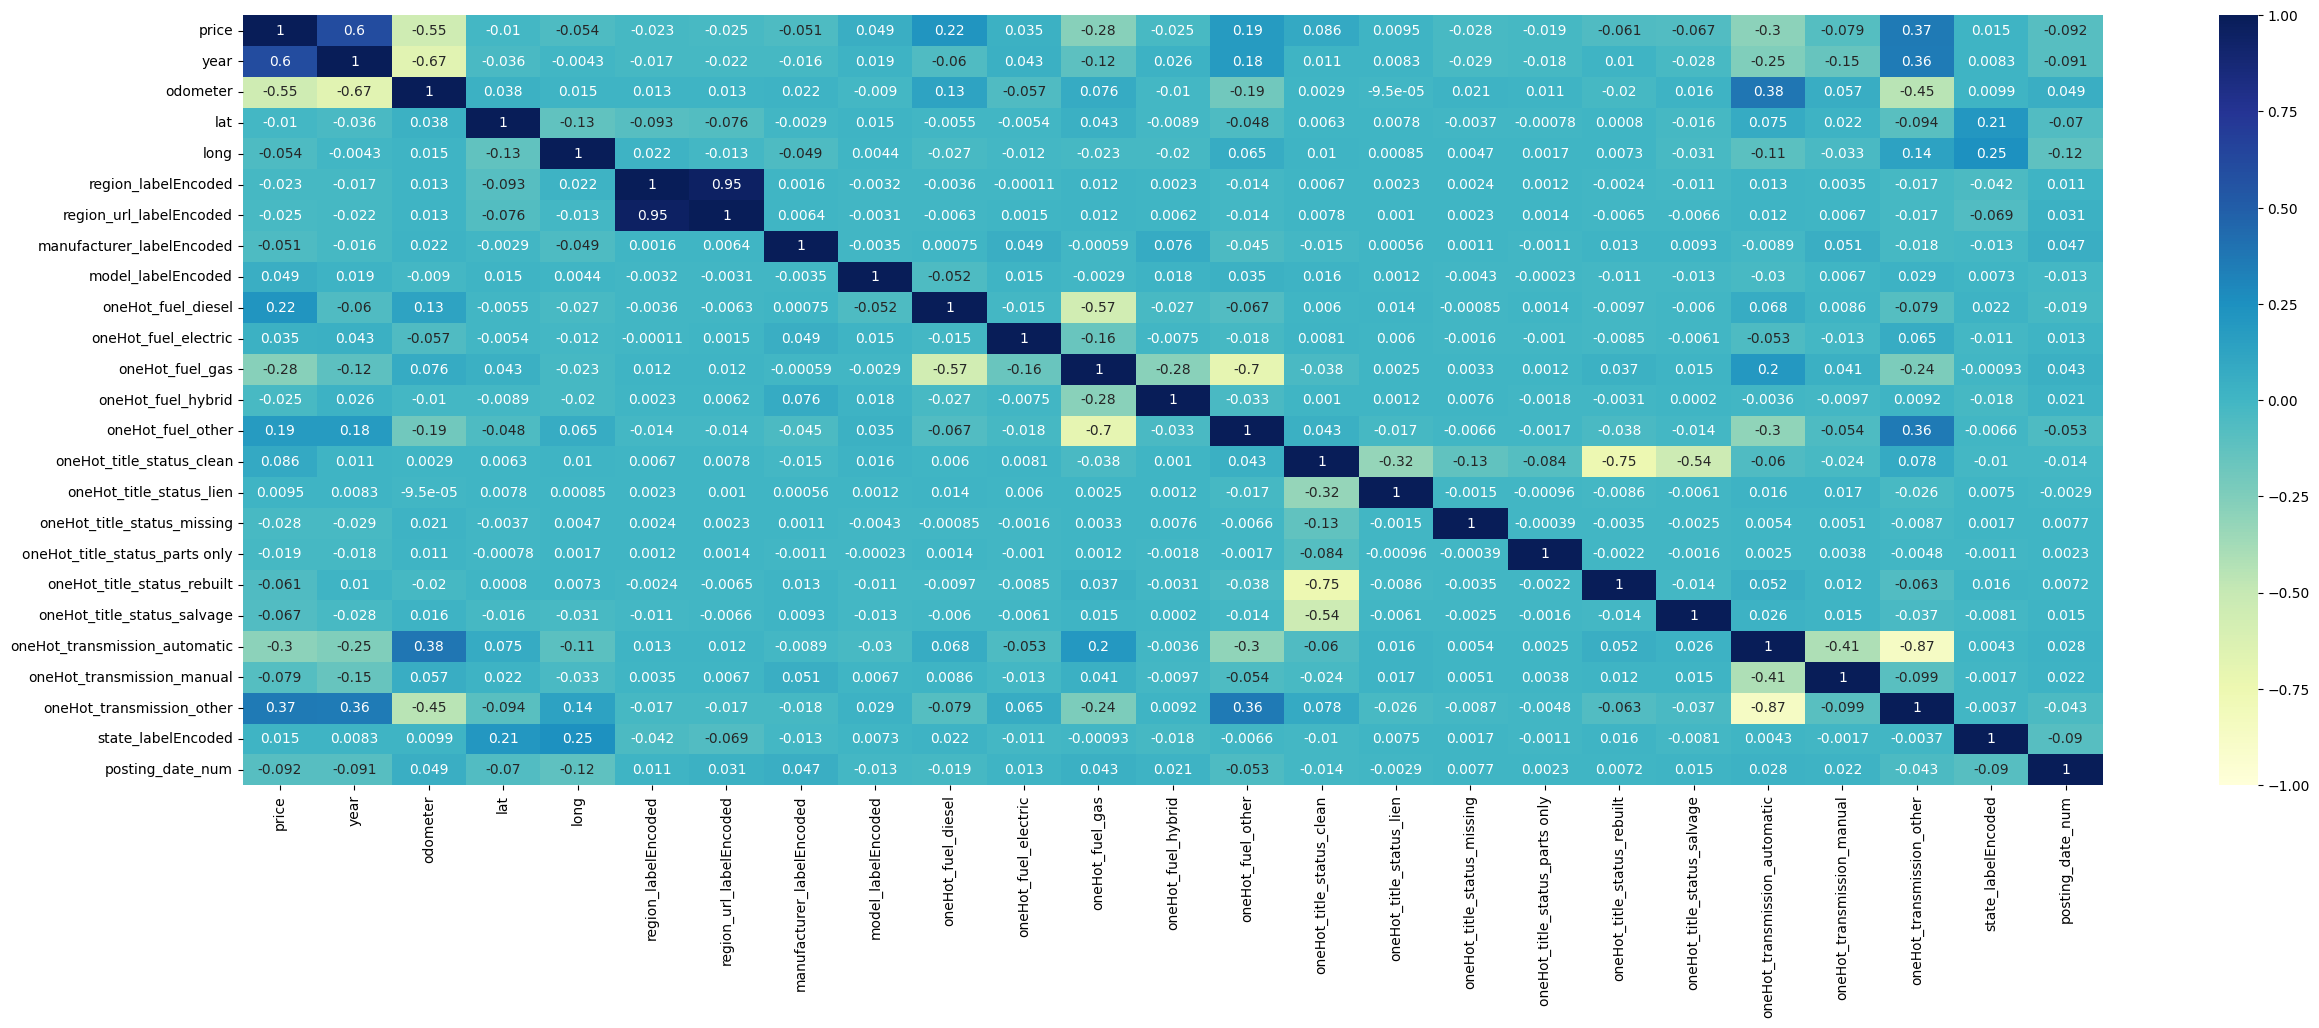

In [51]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(df_num_only_copy_norm.corr(),vmin=-1, vmax=1, cmap="YlGnBu", annot=True)

In [52]:
os.makedirs('../proj6', exist_ok = True)
df_num_only_copy_norm.to_csv('../proj6/vehicles_num.csv', index=False)

In [53]:
###################################################################################################
# Make a Dataset with only Categorical Features
df_cat_only_copy = df_copy.copy()
features_to_drop = df_num_only_copy_norm.columns
df_cat_only_copy = df_cat_only_copy.drop(features_to_drop,axis=1)

df_cat_only_copy.info()

df_cat_only_copy.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337250 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   region                 337250 non-null  category
 1   region_url             337250 non-null  category
 2   manufacturer           337250 non-null  category
 3   model                  337250 non-null  category
 4   fuel                   337250 non-null  category
 5   title_status           337250 non-null  category
 6   transmission           337250 non-null  category
 7   state                  337250 non-null  category
 8   year_qcut              337250 non-null  category
 9   odometer_qcut          337250 non-null  category
 10  lat_qcut               337250 non-null  category
 11  long_qcut              337250 non-null  category
 12  posting_date_num_qcut  337250 non-null  category
 13  price_qcut             337250 non-null  category
dtypes: category(14)
mem

,region,region_url,manufacturer,model,fuel,title_status,transmission,state,year_qcut,odometer_qcut,lat_qcut,long_qcut,posting_date_num_qcut,price_qcut
219694,columbia / jeff city,https://columbiamo.craigslist.org,mitsubishi,outlander sport,gas,clean,other,mo,"(2019.0, 2022.0]","(15926.0, 30255.0]","(37.702, 39.185]","(-94.635, -88.167]","(737809.0, 737812.0]","(17997.0, 23497.0]"
18284,fayetteville,https://fayar.craigslist.org,gmc,sierra 1500 sle 4x4 4dr,gas,clean,automatic,ar,"(2014.0, 2015.0]","(121851.7, 143781.8]","(35.581, 37.702]","(-94.635, -88.167]","(737790.999, 737796.0]","(17997.0, 23497.0]"
166268,"kansas city, MO",https://kansascity.craigslist.org,dodge,challenger,gas,clean,automatic,ks,"(2016.0, 2018.0]","(46181.0, 66842.0]","(37.702, 39.185]","(-94.635, -88.167]","(737809.0, 737812.0]","(28997.0, 35999.0]"


In [54]:
os.makedirs('../proj6', exist_ok = True)
df_cat_only_copy.to_csv('../proj6/vehicles_cat.csv', index=False)